# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW08] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
from typing import Callable, Union, NoReturn, Optional, Dict, Any, List

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [14]:
def gini(x: np.ndarray) -> float:
    """
    Считает коэффициент Джини для массива меток x.
    """
    size = x.shape[0]
    labels, counts = np.unique(x, return_counts=True)
    impurity = sum([cnt / size * (1 - cnt / size) for cnt in counts])
    return impurity
    
def entropy(x: np.ndarray) -> float:
    """
    Считает энтропию для массива меток x.
    """
    size = x.shape[0]
    labels, counts = np.unique(x, return_counts=True)
    impurity = -sum([cnt / size * np.log2(cnt / size) for cnt in counts])
    return impurity

def gain(left_y: np.ndarray, right_y: np.ndarray, criterion: Callable) -> float:
    """
    Считает информативность разбиения массива меток.

    Parameters
    ----------
    left_y : np.ndarray
        Левая часть разбиения.
    right_y : np.ndarray
        Правая часть разбиения.
    criterion : Callable
        Критерий разбиения.
        
    """
    
    left_size = left_y.shape[0]
    right_size = right_y.shape[0]
    
    IG = (left_size + right_size) * criterion(np.concatenate((left_y, right_y))) \
        - left_size * criterion(left_y) - right_size * criterion(right_y) 
    
    return IG

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__

In [149]:
class DecisionTreeLeaf:
    """

    Attributes
    ----------
    y : dict
        Словарь, отображающий метки в вероятность того, что объект, попавший в данный лист, принадлжит классу, 
        соответствующиему метке 
    """
    def __init__(self, y):
        self.y = None
        self.proba = self.count_proba(y)
        
    def count_proba(self, y):
        size = y.shape[0]
        y, counts = np.unique(y, return_counts=True)
        proba = dict(zip(y, counts / size))
        self.y = y[np.argmax(counts)]
        return proba

class DecisionTreeNode:
    """

    Attributes
    ----------
    split_dim : int
        Измерение, по которому разбиваем выборку.
    split_value : float
        Значение, по которому разбираем выборку.
    left : Union[DecisionTreeNode, DecisionTreeLeaf]
        Поддерево, отвечающее за случай x[split_dim] < split_value.
    right : Union[DecisionTreeNode, DecisionTreeLeaf]
        Поддерево, отвечающее за случай x[split_dim] >= split_value. 
    """
    def __init__(self, split_dim: int, split_value: float, 
                 left: Union['DecisionTreeNode', DecisionTreeLeaf], 
                 right: Union['DecisionTreeNode', DecisionTreeLeaf]):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right
        
    def query_explain(self, datapoint, path, features):
        if datapoint[self.split_dim] < self.split_value:
            path.append(f'{features[self.split_dim]} < {self.split_value:.2f}')
            if isinstance(self.left, DecisionTreeLeaf):
                return self.left.proba, path
            return self.left.query_explain(datapoint, path, features)
        
        path.append(f'{features[self.split_dim]} >= {self.split_value:.2f}')
        if isinstance(self.right, DecisionTreeLeaf):
            return self.right.proba, path
        return self.right.query_explain(datapoint, path, features)
        
    def query(self, datapoint):
        
        if datapoint[self.split_dim] < self.split_value:
            if isinstance(self.left, DecisionTreeLeaf):
                return self.left.proba
            return self.left.query(datapoint)
        
        if isinstance(self.right, DecisionTreeLeaf):
            return self.right.proba
        return self.right.query(datapoint)

### Задание 3 (3 балла)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [164]:
class DecisionTreeClassifier:
    """
    Attributes
    ----------
    root : Union[DecisionTreeNode, DecisionTreeLeaf]
        Корень дерева.

    (можете добавлять в класс другие аттрибуты).

    """
    def __init__(self, criterion : str = "gini", 
                 max_depth : Optional[int] = None, 
                 min_samples_leaf: int = 1):
        """
        Parameters
        ----------
        criterion : str
            Задает критерий, который будет использоваться при построении дерева.
            Возможные значения: "gini", "entropy".
        max_depth : Optional[int]
            Ограничение глубины дерева. Если None - глубина не ограничена.
        min_samples_leaf : int
            Минимальное количество элементов в каждом листе дерева.

        """
        if criterion == 'entropy':
            self.criterion = entropy
        else:
            self.criterion = gini
        
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        if max_depth is None:
            self.max_depth = np.inf
        self.root = None
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Строит дерево решений по обучающей выборке.

        Parameters
        ----------
        X : np.ndarray
            Обучающая выборка.
        y : np.ndarray
            Вектор меток классов.
        """
        self.root = self.build_tree(X, y)
        
    def build_tree(self, X, y, depth=0):
        n, m = X.shape
        
        if n <= 2 * self.min_samples_leaf or depth == self.max_depth:
            return DecisionTreeLeaf(y)
        
        ig = -1
        best_feature = 0
        best_split_val = 0
        feature_found = False
        
        for feature in range(m):
            unique_splits = np.unique(X[:, feature])
            data = X[:, feature]
            
            for val in unique_splits:
                cond = (data < val)
                X_left, y_left, X_right, y_right = X[cond], y[cond], X[~cond], y[~cond]
                
                if X_left.shape[0] >= self.min_samples_leaf and X_right.shape[0] >= self.min_samples_leaf:
                    current_ig = gain(left_y=y_left, right_y=y_right, criterion=self.criterion)
                    
                    if current_ig > ig:
                        best_feature = feature
                        best_split_val = val
                        ig = current_ig
                        feature_found = True
                        
        if not feature_found:
            return DecisionTreeLeaf(y)
        
        data = X[:, best_feature]
        cond = (data < best_split_val)
        X_left, y_left, X_right, y_right = X[cond], y[cond], X[~cond], y[~cond]
        
        left_child = self.build_tree(X_left, y_left, depth + 1)
        right_child = self.build_tree(X_right, y_right, depth + 1)
        root = DecisionTreeNode(split_dim=best_feature, split_value=best_split_val, left=left_child, right=right_child)
        
        return root
                
    
    def predict_proba(self, X: np.ndarray) ->  List[Dict[Any, float]]:
        """
        Предсказывает вероятность классов для элементов из X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.
        
        Return
        ------
        List[Dict[Any, float]]
            Для каждого элемента из X возвращает словарь 
            {метка класса -> вероятность класса}.
        """
        preds = []
        
        for x in X:
            if isinstance(self.root, DecisionTreeLeaf):
                preds.append(self.root.proba)
            else:
                preds.append(self.root.query(x))
        
        return preds
    
    def predict(self, X : np.ndarray) -> list:
        """
        Предсказывает классы для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.
        
        Return
        ------
        list
            Вектор предсказанных меток для элементов X.
        """
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [165]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [166]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Наконец, протестируем дерево решений на синтетических наборах данных.

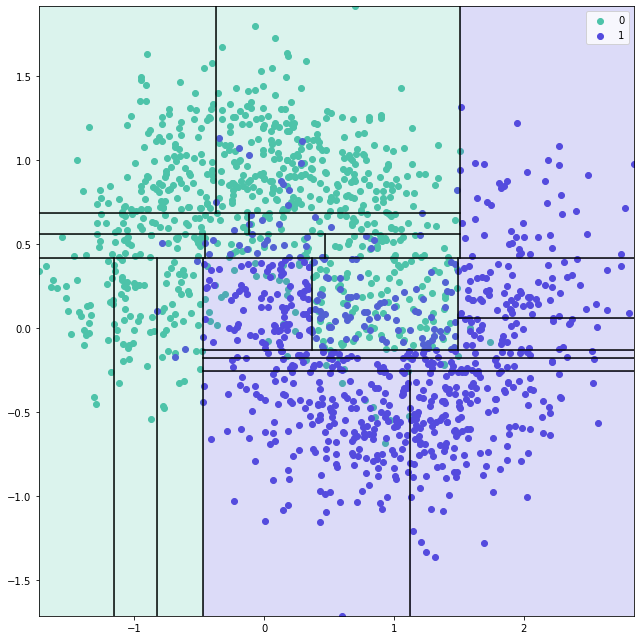

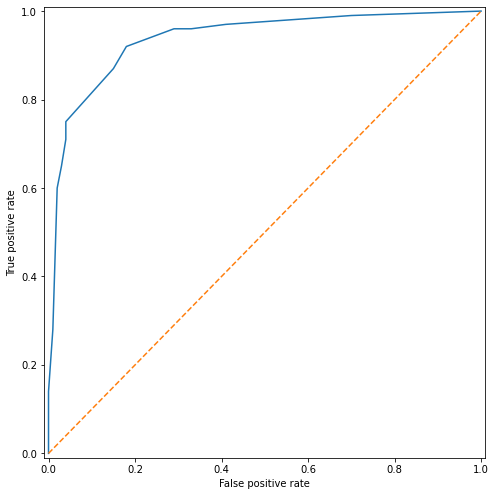

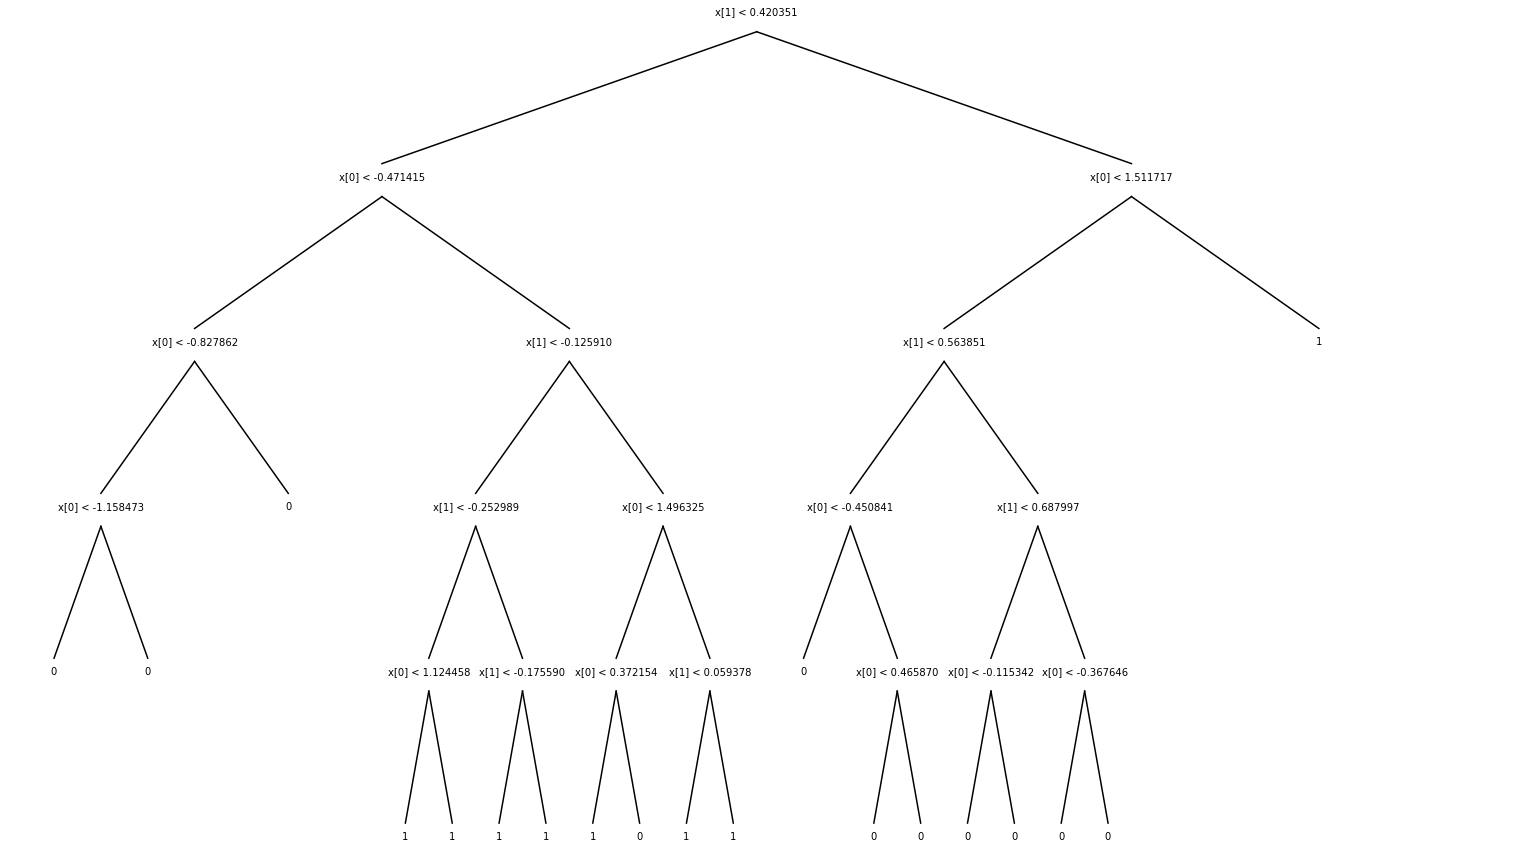

In [168]:
noise = 0.35
X, y = make_moons(1500, noise=noise)
X_test, y_test = make_moons(200, noise=noise)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

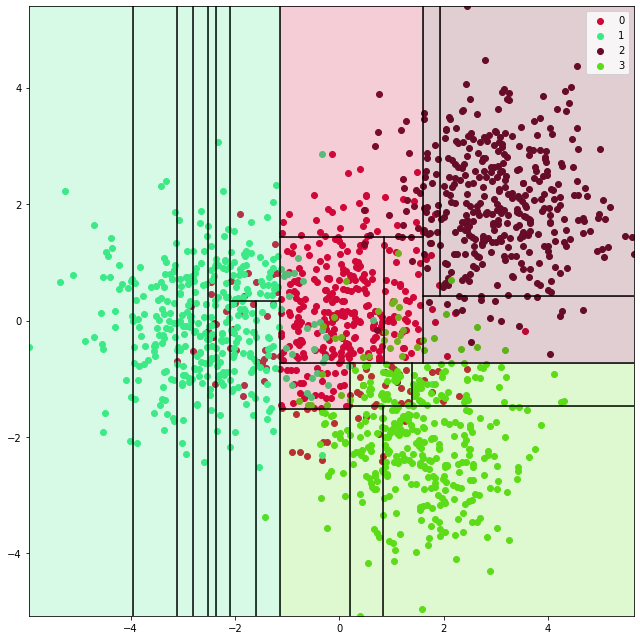

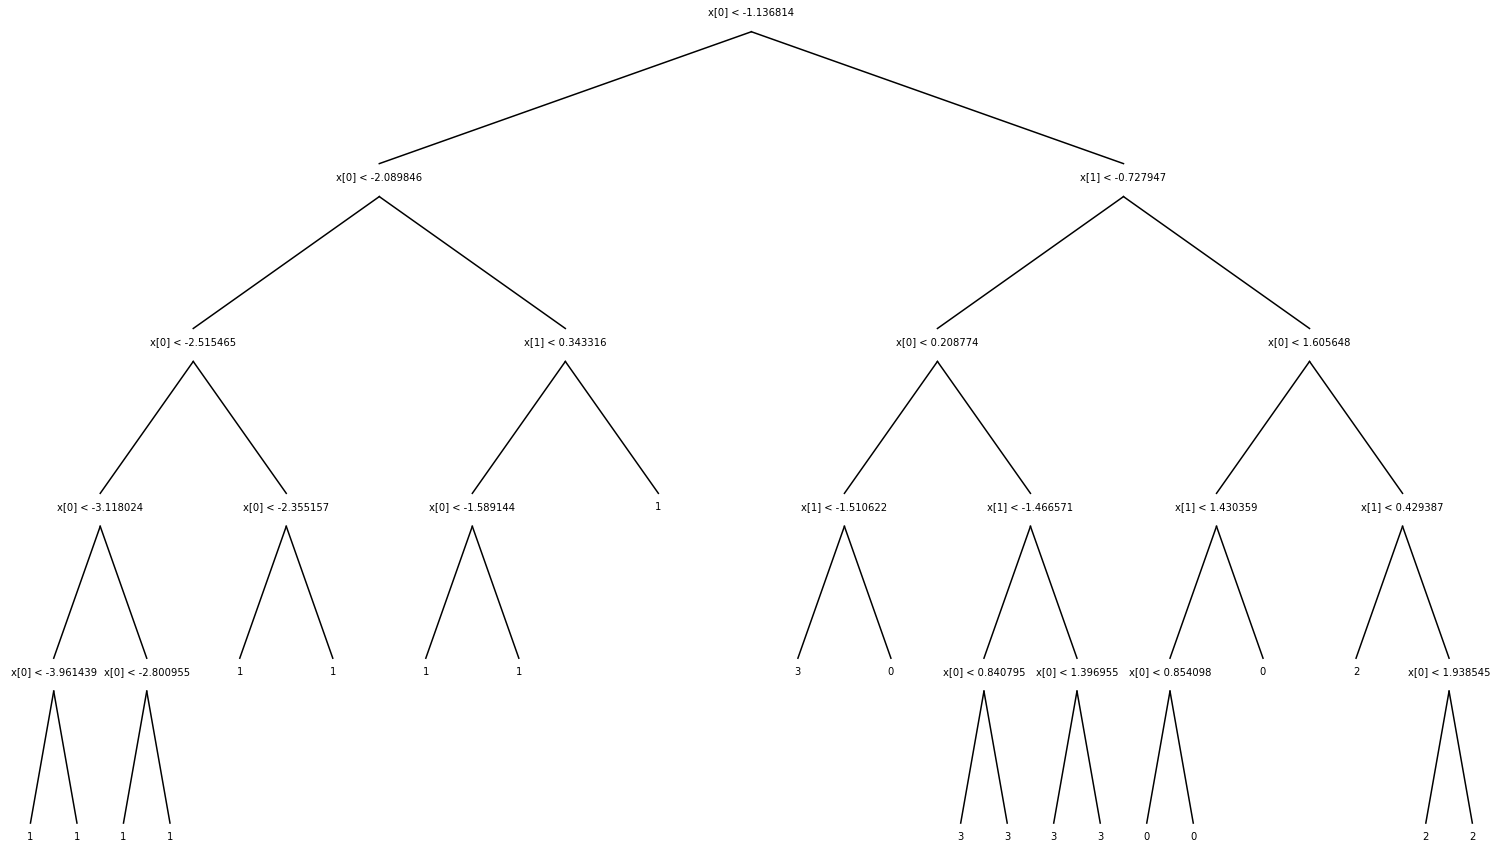

In [171]:
X, y = make_blobs(1500, 2, centers=[[0, 0], [-2.5, 0], [3, 2], [1.5, -2.0]])
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
draw_tree(tree)

### Задание 4 (3 балла)
У малоизвестной MMORPG Smash Art Online удалилась часть базы данных, а бэкапа не оказалось. Уволив сисадмина, тимлид начал думать, как проще и быстрее разрешить ситуацию. Оказалось, что в основном пострадала информация о классах персонажей, но зато часть внутриигровой статистики осталась нетронутой. Было решено не перезапускать игровой мир, а попробовать восстановить утерянные данные.

Посчитав, что ручное восстановление классов персонажей было бы очень долгим и вызвало бы недовольство игроков, тимлид решил пригласить специалиста по машинному обучению, который смог бы восстановить большую часть данных автоматически. 

Ваша задача - построить дерево решений, которое как можно более точно восстанавливает класс персонажа. В этом вам поможет статистика персонажей, а так же сохранившаяся часть классов персонажей. Чтобы дерево было достаточно интерпретируемым, его высота должна быть не больше `6`.


#### Оценка задания
Баллы за это задание выставляются в зависимости от точности полученного классификатора на закрытой части выборки:
1. __Точность > 50%__ - 1 балл - классификатор значительно облегчил команде игры задачу по восстановлению классов игроков. Тимлид доволен и, вероятно, захочет продолжить сотрудничество в дальнейшем
2. __Точность > 85%__ - 3 балла - классификатор сделал большую часть работы. Довольный тимлид задумчиво чешет подбородок, а затем предлагает сотрудничество на постоянной основе

__Важно: метки классов - названия, а не числа. Пусть так и остается.__

In [150]:
def read_dataset(path):
    random.seed(10)
    dataframe = pandas.read_csv(path, header=1)
    dataset = dataframe.values.tolist()
    random.shuffle(dataset)
    y = [row[0] for row in dataset]
    X = [row[1:] for row in dataset]
    return np.array(X), np.array(y)

In [151]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [152]:
def cross_val(clf, X, y, k=5):
    scores = np.array([])
    kf = KFold(n_splits=k, shuffle=False)
    i = 1
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        scores = np.append(scores, acc)
        print(f'accuracy at iter {i}: {acc:.4f}')
        i+=1
    return np.mean(acc)

In [177]:
X, y = read_dataset("train.csv")

dtc = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)
print(f'\nmean accuracy for {10} splits: {cross_val(dtc, X, y, k = 10):.5f}')

accuracy at iter 1: 0.9333
accuracy at iter 2: 0.9667
accuracy at iter 3: 0.8833
accuracy at iter 4: 0.8667
accuracy at iter 5: 0.8833
accuracy at iter 6: 0.8667
accuracy at iter 7: 0.9000
accuracy at iter 8: 0.8333
accuracy at iter 9: 0.8667
accuracy at iter 10: 0.8814

mean accuracy for 10 splits: 0.88136


In [154]:
dtc.fit(X, y)

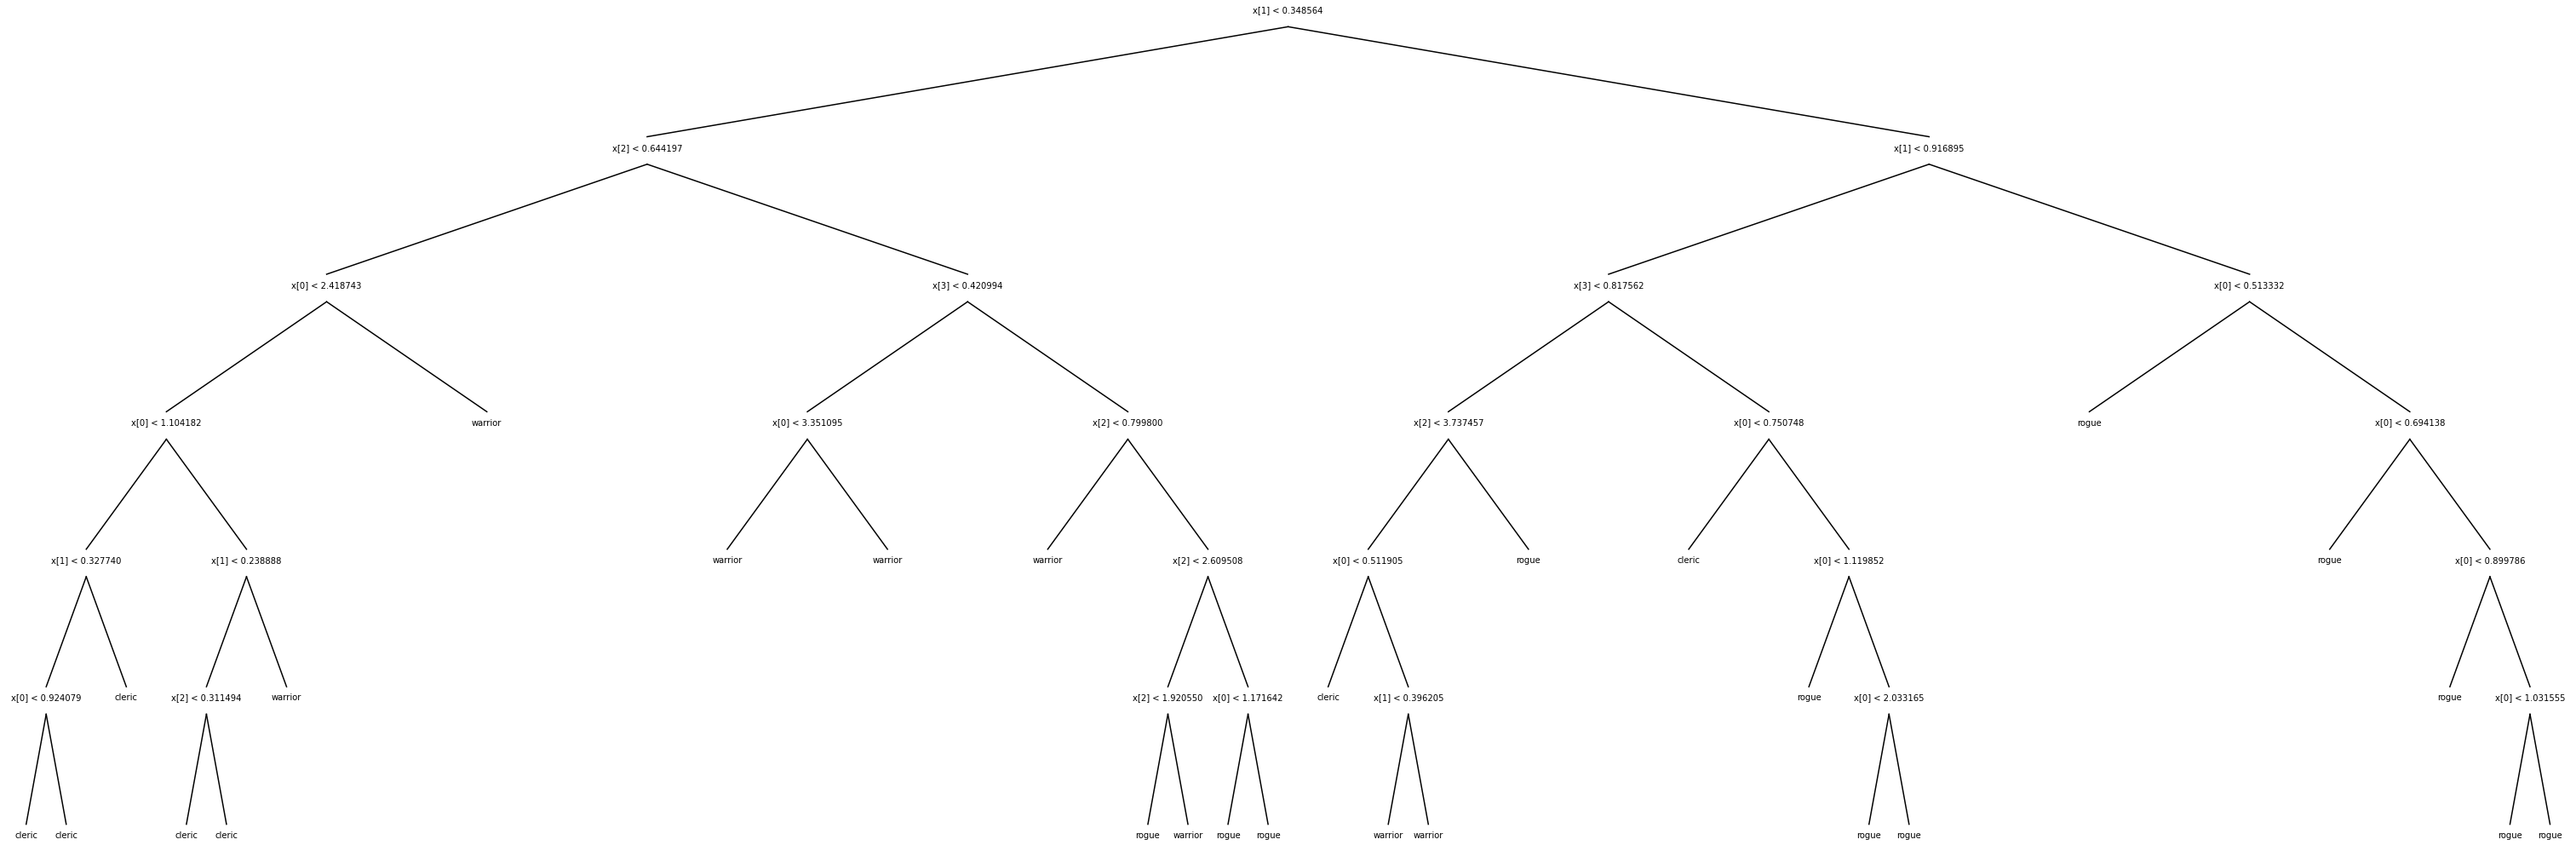

In [126]:
draw_tree(dtc)

### Задание 5 (1 балл)
От игроков начали поступать жалобы на то, что класс их персонажа внезапно сменился. В таких случаях модераторы смотрят на данные персонажа и пытаются восстановить его класс сами. Для того, чтобы им было проще это сделать, нужно научиться для каждого персонажа объяснять, почему дерево решений присвоило персонажу именно такой класс.

Реализуйте функцию `predict_explain(dtc, X)`. Для каждого элемента элемента набора данных `X` она должна вернуть пару из предсказанного класса и человекочетаемой строковой записи условий, благодаря которым был предсказан класс. 

In [162]:
def predict_explain(dtc: DecisionTreeClassifier, X: np.ndarray):
    proba = []
    explanations = []
    dataframe = pandas.read_csv('train.csv', header=0)
    features = dataframe.columns.values
    
    for x in X:
        if isinstance(dtc, DecisionTreeLeaf):
            preds.append(dtc.proba)
        else:
            p, explain = dtc.root.query_explain(x, path=[], features=features)
            proba.append(p)
            explanations.append('; '.join(explain))
    
    classes = [max(p.keys(), key=lambda k: p[k]) for p in proba]

    return zip(classes, explanations)
    

In [163]:
X, y = read_dataset("train.csv")
for pred_y, expl in predict_explain(dtc, X[:20]):
    print("Class:", pred_y)
    print("Explanation:", expl)
    print()

Class: cleric
Explanation: monster kills per death < 0.35; death in pvp percentage < 0.64; class < 2.42; class < 1.10; monster kills per death < 0.33; class < 0.92

Class: rogue
Explanation: monster kills per death >= 0.35; monster kills per death >= 0.92; class >= 0.51; class >= 0.69; class >= 0.90; class >= 1.03

Class: rogue
Explanation: monster kills per death >= 0.35; monster kills per death >= 0.92; class >= 0.51; class >= 0.69; class >= 0.90; class >= 1.03

Class: rogue
Explanation: monster kills per death >= 0.35; monster kills per death >= 0.92; class >= 0.51; class >= 0.69; class >= 0.90; class >= 1.03

Class: rogue
Explanation: monster kills per death >= 0.35; monster kills per death >= 0.92; class >= 0.51; class >= 0.69; class >= 0.90; class >= 1.03

Class: cleric
Explanation: monster kills per death < 0.35; death in pvp percentage < 0.64; class < 2.42; class < 1.10; monster kills per death < 0.33; class < 0.92

Class: warrior
Explanation: monster kills per death >= 0.35; m